In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)
print(path.ls())


[Path('/root/.fastai/data/oxford-iiit-pet/annotations'), Path('/root/.fastai/data/oxford-iiit-pet/images')]


In [ ]:
(path/"images").ls()[:5]


(#5) [Path('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_155.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_setter_160.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/beagle_61.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Bombay_200.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Bengal_148.jpg')]

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(640),
    batch_tfms=aug_transforms(size=640)
)


In [ ]:
dls = dblock.dataloaders(path/"images")


In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(640),                      # Presizing
    batch_tfms=aug_transforms(
        size=224,               # Final size
        flip_vert=True,         # vertical flip
        max_rotate=20.0,        # more sharper rotations
        max_zoom=1.1,           #  zooming
        max_lighting=0.2,       #  lighting
        max_warp=0.2            # deformation
    )
)



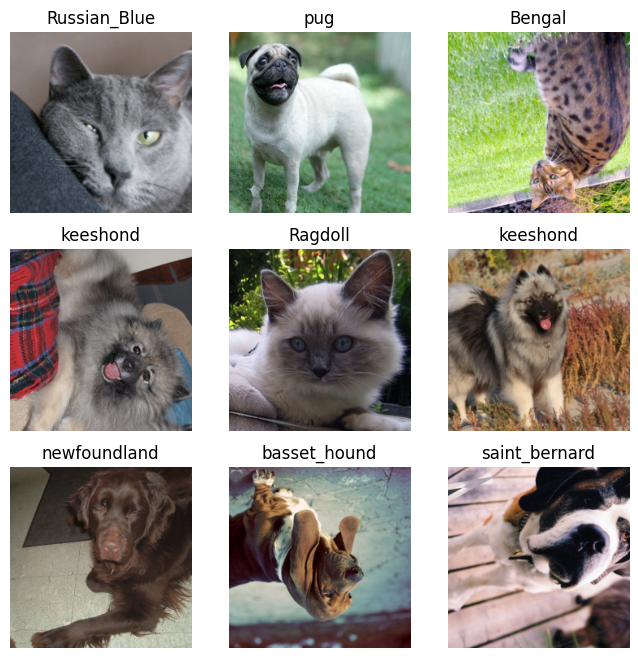

In [ ]:
dls = dblock.dataloaders(path/"images")
dls.show_batch(max_n=9, figsize=(8,8))


In [ ]:
print(dls.vocab)
print(f"Total number of classes: {len(dls.vocab)}")


['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']
Total number of classes: 37


In [ ]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.model
learn.summary()


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 168MB/s]


Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']
5912 1478


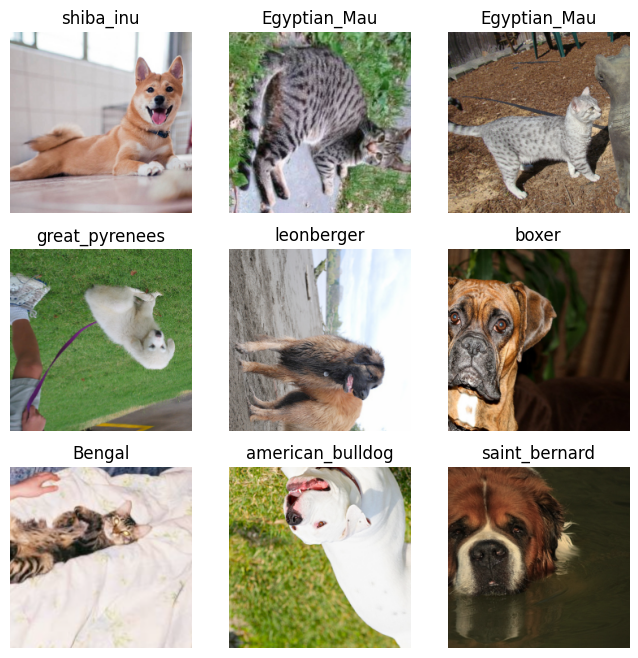

In [ ]:
dls.show_batch(max_n=9, figsize=(8,8))        # shows images and their labels
print(dls.vocab)                              # labels
print(len(dls.train_ds), len(dls.valid_ds))   # Train and valid sizes

epoch,train_loss,valid_loss,accuracy,time
0,1.973364,0.348879,0.882950,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.790318,0.302545,0.905954,00:16
1,0.639061,0.265705,0.919486,00:16
2,0.444025,0.216231,0.929635,00:16


Accuracy: 0.9296


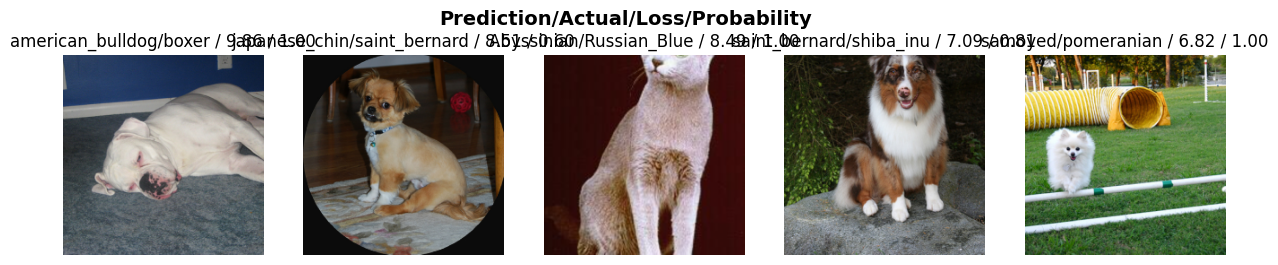

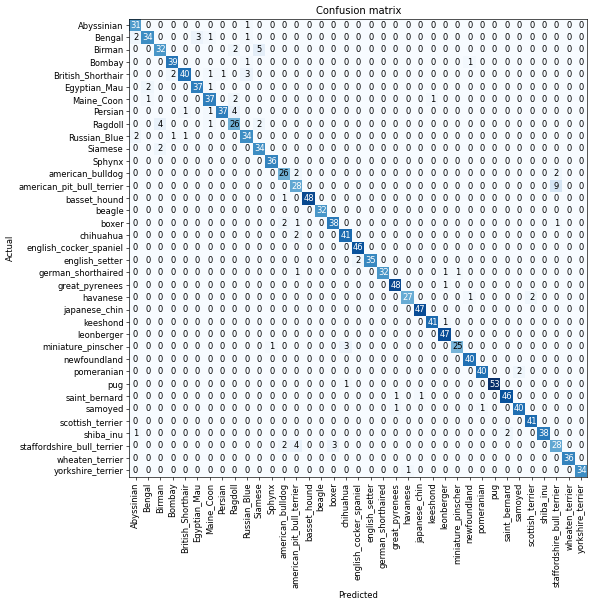

In [ ]:
# benchmark and training
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(3)

# interpreting and confisuon matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(5, nrows=1)
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

# accuracy rate
print(f"Accuracy: {learn.validate()[1]:.4f}")


AttributeError: 'SuggestedLRs' object has no attribute 'plot'

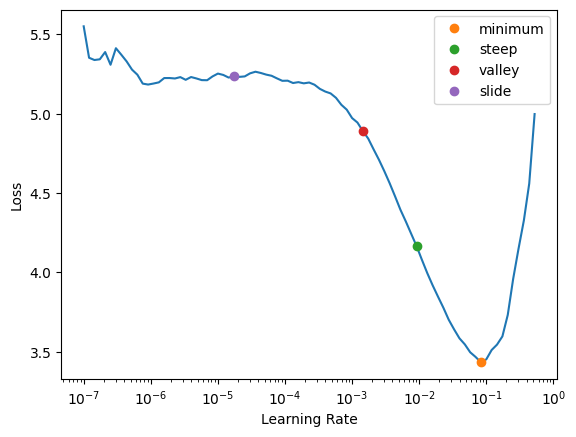

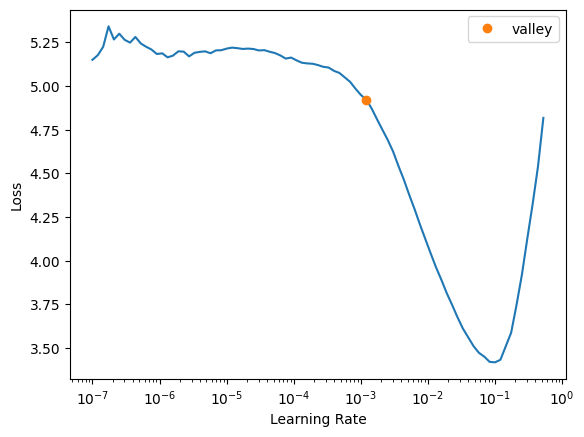

In [ ]:
from fastai.vision.all import *


learn = vision_learner(dls, resnet34, metrics=accuracy)


suggestions = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))


learn.lr_find().plot()


print("Suggesting Learning Rate ")
for key, val in suggestions.items():
    print(f"{key}: {val:.2e}")


In [ ]:
from fastai.vision.all import *

# Modeli oluştur ve açıkça GPU'ya taşı
learn = vision_learner(dls, resnet34, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.to_fp32()           # mixed precision varsa düzelt
learn.model = learn.model.to(default_device())  # MODELİ GPU'YA TAŞI
learn.model.train()

# Başlangıç learning rate
lr = 1e-5
opt = learn.opt_func(learn.parameters(), lr=lr)

# ✅ Veriyi de GPU'ya taşı
xb, yb = to_device(dls.one_batch(), default_device())

# İlk loss hesaplama
old_loss = learn.loss_func(learn.model(xb), yb)
print(f"Initial LR: {lr:.1e} → Loss: {old_loss.item():.4f}")

# LR artırma döngüsü
for i in range(10):
    lr *= 2
    opt = learn.opt_func(learn.parameters(), lr=lr)
    opt.zero_grad()

    preds = learn.model(xb)
    loss = learn.loss_func(preds, yb)
    loss.backward()
    opt.step()

    print(f"Step {i+1} | LR: {lr:.1e} → Loss: {loss.item():.4f}")

    if loss.item() > old_loss.item():
        print(" Loss increased, early stopping performed")
        break
    else:
        old_loss = loss



Initial LR: 1.0e-05 → Loss: 5.6044
Step 1 | LR: 2.0e-05 → Loss: 5.2122
Step 2 | LR: 4.0e-05 → Loss: 5.3951
 Loss increased, early stopping performed


In [ ]:
from fastai.vision.all import *


learn = vision_learner(dls, resnet34, metrics=accuracy)


learn.freeze()
print("🧊 Only final layer (F') is being trained.")
learn.fit_one_cycle(1)


learn.unfreeze()
print(" Now training entire model (F' + pretrained layers).")
learn.fit_one_cycle(3, lr_max=1e-3)


🧊 Only final layer (F') is being trained.


epoch,train_loss,valid_loss,accuracy,time
0,1.740182,0.378865,0.878890,00:15


 Now training entire model (F' + pretrained layers).


epoch,train_loss,valid_loss,accuracy,time
0,1.797882,2.540649,0.414750,00:16
1,1.351900,0.678640,0.781461,00:16
2,0.815220,0.359550,0.880244,00:16


Freeze


epoch,train_loss,valid_loss,accuracy,time
0,1.722262,0.374002,0.882273,00:16


Unfreeze + Discriminative LR


epoch,train_loss,valid_loss,accuracy,time
0,0.975562,0.299184,0.902571,00:16
1,0.745430,0.283775,0.905277,00:16
2,0.554284,0.229099,0.926928,00:16
3,0.450451,0.216529,0.933018,00:16
4,0.401001,0.208016,0.929635,00:16


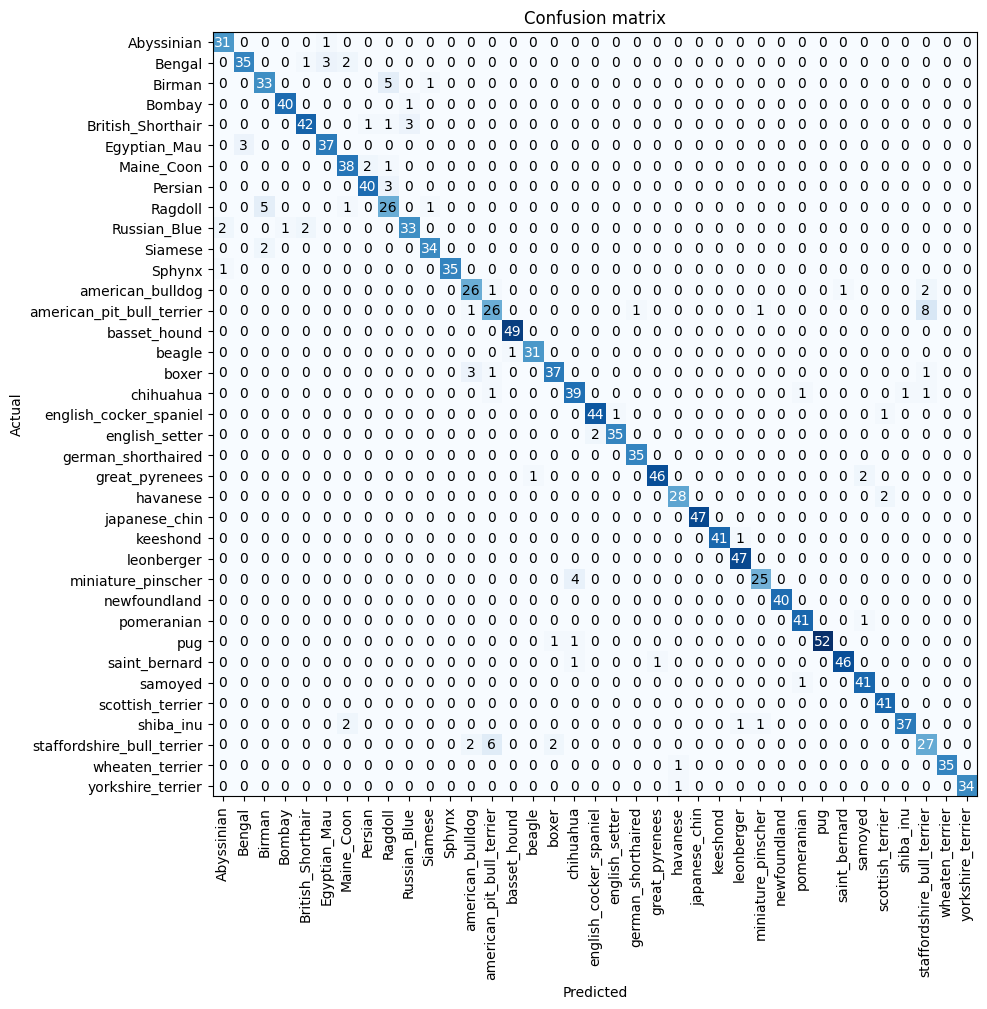

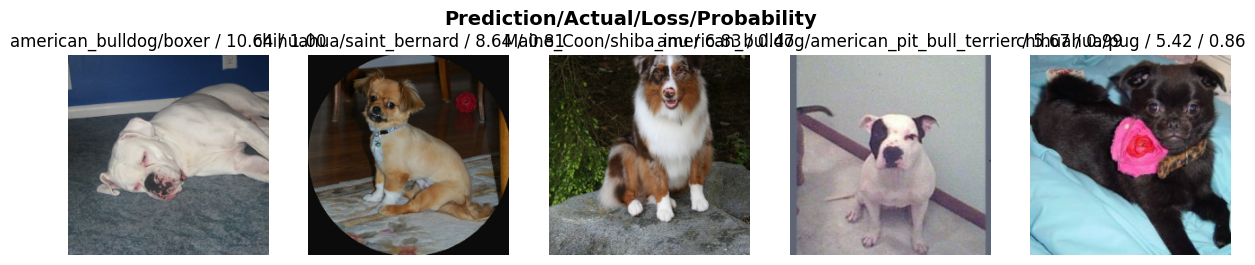

In [ ]:
from fastai.vision.all import *


learn = vision_learner(dls, resnet34, metrics=accuracy)


print("Freeze")
learn.freeze()
learn.fit_one_cycle(1)


learn.unfreeze()


print("Unfreeze + Discriminative LR")
learn.fit_one_cycle(5, lr_max=slice(1e-6, 1e-3))


interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))
interp.plot_top_losses(5, nrows=1)


 Learning Rate Finder runs


suggested valley learning rate: 6.92e-04


epoch,train_loss,valid_loss,accuracy,time
0,2.837604,0.494133,0.857916,00:16


epoch,train_loss,valid_loss,accuracy,time
0,1.202556,0.300548,0.904601,00:16
1,0.868349,0.245626,0.915426,00:16
2,0.644195,0.213285,0.930988,00:16
3,0.514734,0.197107,0.936401,00:16
4,0.470084,0.197209,0.935724,00:16


 Early stopping is not used because early stopping and lr finder are not suit each other.


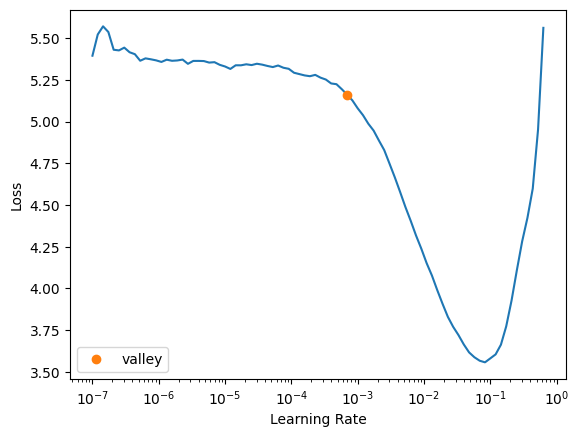

In [ ]:
from fastai.vision.all import *


learn = vision_learner(dls, resnet34, metrics=accuracy)


print(" Learning Rate Finder runs")
lr_suggestion = learn.lr_find(suggest_funcs=(valley,))
valley_lr = lr_suggestion.valley
print(f"suggested valley learning rate: {valley_lr:.2e}")



learn.fine_tune(5, base_lr=valley_lr)


print(" Early stopping is not used because early stopping and lr finder are not suit each other.")


Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:00<00:00, 216MB/s]


Training starts with a larger model, smaller batch size, and mixed precision.


/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,time
0,1.037583,0.374978,0.889039,00:43


epoch,train_loss,valid_loss,accuracy,time
0,0.579804,0.236345,0.925575,00:50
1,0.456157,0.198015,0.938430,00:50
2,0.234745,0.200834,0.940460,00:50
3,0.212537,0.197793,0.943166,00:50
4,0.131120,0.199955,0.940460,00:50


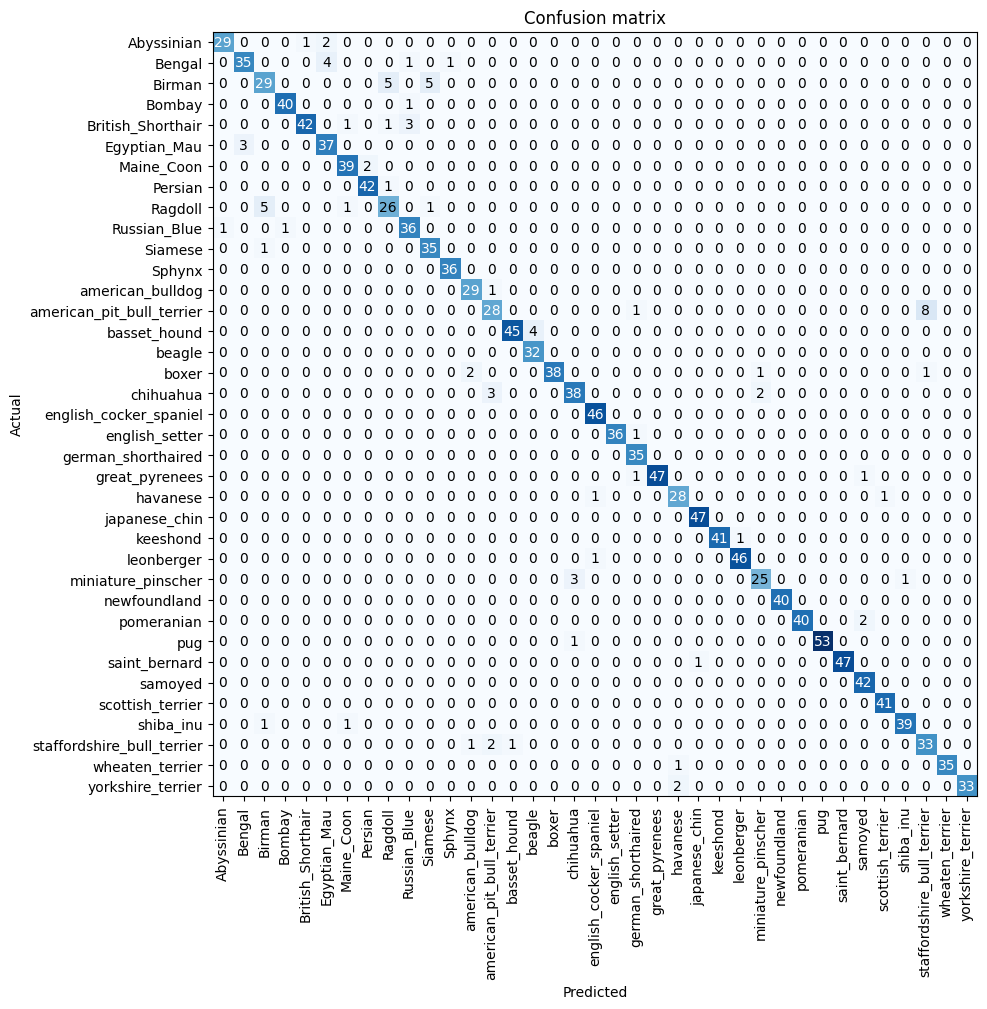

In [ ]:
from fastai.vision.all import *


bs = 16


dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(640),
    batch_tfms=aug_transforms(size=224)
)

dls = dblock.dataloaders(path/"images", bs=bs)


learn = vision_learner(dls, resnet101, metrics=accuracy)


learn = learn.to_fp16()


print("Training starts with a larger model, smaller batch size, and mixed precision.")
learn.fine_tune(5, base_lr=1e-3)


interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))


In [ ]:
learn.export('ArdaBaran_ADA447_MidtermProject_PetBreedClassifier.pkl')
